In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, beta

from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt 

## Experiment Definition

We're testing a new Variant version of way to show customer when checking out. Guest rating of Hotels v.s. Start ratings

Control: Star rating of hotels ( Text based ) \
Treatment: Guest Rating of Hotels ( visual based)

### Hypothesis
By replacing start ratings with cusotmers guest rting will reinforce confidence that the user has made the right choice and therefore increase their LIKELIHOOD to purchase


How do you think the experiment will work?\
Do we have actionable next steps laid out?

In [2]:
df_raw = pd.read_csv('Files/sample_data.csv')

In [3]:
df_raw.head(2)
df_raw.shape
#checking NAs
df_raw.isnull().values.any()


df = df_raw
df.shape

,user_id,experiment_variant_code,new_return_visitor,platform_type,posa_super_region,marketing_channel,orders,room_nights,booking_gbv
0,1,VARIANT,RETURN,TABWEB,EMEA,SEM,0,0,0.0
1,2,CONTROL,NEW,MOBILE,APAC,SEM,0,0,0.0


(2003501, 9)

False

(2003501, 9)

In [4]:
#Check the balance of test v.s. chontrol size
print(f"Percentage of users in control: {round(df[df['experiment_variant_code']=='CONTROL'].shape[0] * 100 / df.shape[0])}%")


Percentage of users in control: 50%


## data preprocessing

In [5]:
df = df[df['orders'] >= 0]
df = df[df['room_nights'] >= 0]
df = df[df['booking_gbv'] >= 0]

df.shape

df['Converted'] = np.where(df['orders']> 0, 1, 0)
df['Converted'].value_counts()
df.shape



# df.groupby(['Converted', 'experiment_variant_code']).size().unstack(fill_value=0)

df.groupby(['experiment_variant_code', 'new_return_visitor', 'platform_type']).size().unstack(fill_value=0)
df.groupby(['experiment_variant_code', 'new_return_visitor', 'posa_super_region']).size().unstack(fill_value=0)
df.groupby(['experiment_variant_code', 'new_return_visitor', 'marketing_channel']).size().unstack(fill_value=0)

(1988892, 9)

0    1819470
1     169422
Name: Converted, dtype: int64

(1988892, 10)

platform_type                               DESKTOP  IAPP  IPAD  MOBILE  \
experiment_variant_code new_return_visitor                                
CONTROL                 NEW                  235752     7     0  351102   
                        RETURN               170463    63     5  170218   
                        UNKNOWN                3322     2     0    6992   
VARIANT                 NEW                  236296     6     0  351202   
                        RETURN               169440    53     1  169565   
                        UNKNOWN                3251     0     0    6774   

platform_type                               TABWEB  UNKNOWN  
experiment_variant_code new_return_visitor                   
CONTROL                 NEW                  34673        0  
                        RETURN               21446        6  
                        UNKNOWN                814        0  
VARIANT                 NEW                  35047        0  
                        RETURN               21514        3  
                        UNKNOWN                875        0

posa_super_region                             APAC    EMEA  LATAM    N_AM  \
experiment_variant_code new_return_visitor                                  
CONTROL                 NEW                 111431  246442  67317  190717   
                        RETURN               62114  139232  36417  121009   
                        UNKNOWN                789    4532   1002    4718   
VARIANT                 NEW                 111913  246275  67521  191114   
                        RETURN               61928  138868  36388  120093   
                        UNKNOWN                808    4478   1048    4479   

posa_super_region                           UNKNOWN  
experiment_variant_code new_return_visitor           
CONTROL                 NEW                    5627  
                        RETURN                 3429  
                        UNKNOWN                  89  
VARIANT                 NEW                    5728  
                        RETURN                 3299  
                        UNKNOWN                  87

marketing_channel                           DIRECT  EMAIL    META     SEM  \
experiment_variant_code new_return_visitor                                  
CONTROL                 NEW                 143850  25766  146972  248992   
                        RETURN               78859  41817   72912  135201   
                        UNKNOWN               3093   1575    1877    3743   
VARIANT                 NEW                 143450  26038  147934  248907   
                        RETURN               78844  41511   72249  135024   
                        UNKNOWN               3006   1578    1897    3581   

marketing_channel                             SEO  
experiment_variant_code new_return_visitor         
CONTROL                 NEW                 55954  
                        RETURN              33412  
                        UNKNOWN               842  
VARIANT                 NEW                 56222  
                        RETURN              32948  
                        UNKNOWN               838

## Frequentist Approach
### Chi-squared test

Ho:  Treatment and control groups are from the same dist | No evidence that user behavior are different\
H1:  Treatment and control groups are not from the same dist | Some evidence that user behavior are different


In [6]:
# Get Stats, creating stratified sub-samples of experimental data to 
# _, experiment_data = train_test_split(df, test_size=0.95, stratify=df[['experiment_variant_code','new_return_visitor','posa_super_region','marketing_channel']])
experiment_data = df
experiment_data.shape[0]

print(f"Percentage of users in control: {round(experiment_data[experiment_data['experiment_variant_code']=='CONTROL'].shape[0] * 100 / experiment_data.shape[0])}%")

control = experiment_data[experiment_data['experiment_variant_code']=='CONTROL']
treatment = experiment_data[experiment_data['experiment_variant_code']=='VARIANT']

control_conversion_perc = round(control['Converted'].sum() * 100/ control['Converted'].count(), 3)
treatment_conversion_perc = round(treatment['Converted'].sum() * 100/ treatment['Converted'].count(), 3)
lift = round(treatment_conversion_perc - control_conversion_perc, 3)

print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

1988892

Percentage of users in control: 50%
Treatment Conversion Rate: 8.533%
Control Conversion Rate: 8.504%
Lift = 0.029%


In [7]:
# Create Contingency Table for Chi Squared Test
control_converted = control['Converted'].sum()
treatment_converted = treatment['Converted'].sum()
control_non_converted = control['Converted'].count() - control_converted
treatment_non_converted = treatment['Converted'].count() - treatment_converted
contingency_table = np.array([[control_converted, control_non_converted], 
                              [treatment_converted, treatment_non_converted]])

In [8]:
contingency_table

array([[ 84606, 910259],
       [ 84816, 909211]])

In [9]:
chi, p_value, _, _ = chi2_contingency(contingency_table, correction=False)

In [10]:
chi, p_value

(0.5108533627159144, 0.4747696750723204)

## Bayesian Approach

Construct our prior distribution and have the experiment update the parameter to create posterier distributions. The distributions we will be using are conversion rate theregore we simulate with a beta distribution


In [11]:
# Create a stratified sample out of total

experiment_data1, experiment_data0 = train_test_split(df, test_size=0.3, stratify=df[['experiment_variant_code', 'new_return_visitor','posa_super_region','marketing_channel']])


In [16]:
prior = experiment_data0[experiment_data0['experiment_variant_code'] =='CONTROL']
experiment_data0.shape[0]
experiment_data1.shape[0]

596668

1392224

In [17]:
prior_means = []
for i in range(10000):
    prior_means.append(prior.sample(1000)['Converted'].mean())

In [18]:
len(prior_means)


10000

In [19]:
# Model Beta Distribtion from sample means
prior_alpha, prior_beta, _, _ = beta.fit(prior_means, floc=0, fscale=1)
prior_alpha, prior_beta

(87.28737510187528, 938.5963111606751)

In [20]:
# Get Stats
experiment_data = experiment_data1
control = experiment_data[experiment_data['experiment_variant_code']=='CONTROL']
treatment = experiment_data[experiment_data['experiment_variant_code']=='VARIANT']

control_conversion_perc = round(control['Converted'].sum() * 100/ control['Converted'].count(), 3)
treatment_conversion_perc = round(treatment['Converted'].sum() * 100/ treatment['Converted'].count(), 3)
lift = round((treatment_conversion_perc - control_conversion_perc) / control_conversion_perc , 3)
print(f"Treatment Conversion Rate: {treatment_conversion_perc}%")
print(f"Control Conversion Rate: {control_conversion_perc}%")
print(f"Lift = {lift}%")

Treatment Conversion Rate: 8.536%
Control Conversion Rate: 8.507%
Lift = 0.003%


In [23]:
control_converted = control['Converted'].sum()
treatment_converted = treatment['Converted'].sum()
control_non_converted = control['Converted'].count() - control_converted
treatment_non_converted = treatment['Converted'].count() - treatment_converted
# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)
# Sample from Posteriors, with Monte Carlo Simulation to 50000 trails
n_trails = 5000
control_samples  = pd.Series([posterior_control.rvs() \
                            for _ in range(n_trails)])

treatment_samples = pd.Series([posterior_treatment.rvs() \
                            for _ in range(n_trails)])

                               
probability = np.mean(treatment_samples > control_samples)
print(f"Probability that treatment > control: {probability * 100}%")



Probability that treatment > control: 72.52%


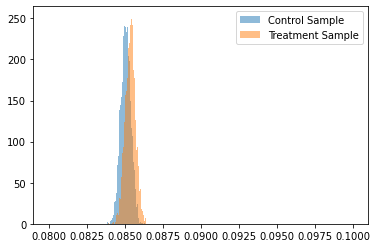

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot of the distribution of control and treamtment samples
bins = np.linspace(0.08, 0.1, 500)
_ =plt.hist(control_samples, bins, alpha=0.5, label='Control Sample')
_ =plt.hist(treatment_samples, bins, alpha=0.5, label='Treatment Sample')
_ =plt.legend(loc='upper right')
plt.show()

plt.savefig('Bayesian.png')


# Brelativer = treatment_samples/control_samples
# Brelativer.hist()

In [40]:
(control_mu), (control_var) = posterior_control.stats()
(treatment_mu), (treatment_var) = posterior_treatment.stats()
print(f"Control Posterior: Mean: {control_mu}, Variance: {control_var}") 
print(f"Treatment Posterior: Mean: {treatment_mu}, Variance: {treatment_var}") 

Control Posterior: Mean: 0.08487219049141163, Variance: 1.1137381418893422e-07
Treatment Posterior: Mean: 0.08521817414194399, Variance: 1.1188020796669954e-07


In [37]:
lift_percentage = (treatment_samples - control_samples) / control_samples
print(f"Probability that we are seeing a .5% lift: {np.mean((100 * lift_percentage) > 0.5) * 100}%")

Probability that we are seeing a .5% lift: 43.43%
